In [ ]:
import pandas as pd

EVO_pinn = pd.read_csv('/data/EVO.csv')

In [3]:
EVO_pinn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61368 entries, 0 to 61367
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dia               61368 non-null  object 
 1   Tm                61355 non-null  float64
 2   Tmax              61363 non-null  float64
 3   Tmin              61364 non-null  float64
 4   Velocitat_vent    61368 non-null  float64
 5   HRmd              61356 non-null  float64
 6   HRmax             61363 non-null  float64
 7   Precipitacio      61368 non-null  float64
 8   Irradiacio_solar  61361 non-null  float64
 9   ETo               61216 non-null  float64
 10  Clima             61368 non-null  object 
 11  Lat               61368 non-null  float64
 12  EMA               61368 non-null  object 
 13  Any               61368 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 6.6+ MB


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import tensorflow as tf
import os
import random

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

df = EVO_pinn

#Eliminació nulls per segueretat
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df['Dia'] = pd.to_datetime(df['Dia'])
df['D'] = df['Dia'].dt.dayofyear


# Creació variable dia en ciclica
df['Dia_sin'] = np.sin(2 * np.pi * df['D'] / 365.0)
df['Dia_cos'] = np.cos(2 * np.pi * df['D'] / 365.0)


# Codificació varaible categorica tipus de clima
le_clima = LabelEncoder()
df['Clima_enc'] = le_clima.fit_transform(df['Clima'])
num_classes_clima = len(np.unique(df['Clima_enc']))

# Conjunts variables i variable objectiu
X_num = df[['Tmax', 'Irradiacio_solar', 'Dia_sin', 'Dia_cos']].values
X_clima = df['Clima_enc'].values
y = df['ETo'].values
temp = df['Tm'].values

# Divisió entrenament/test
X_num_train, X_num_test, X_clima_train, X_clima_test, temp_train, temp_test, y_train, y_test = train_test_split(
    X_num, X_clima, temp, y, test_size=0.2, random_state=SEED
)

In [5]:
# Escalant X
scaler_X = StandardScaler()
X_num_train_scaled = scaler_X.fit_transform(X_num_train)
X_num_test_scaled = scaler_X.transform(X_num_test)

# Escalat y
scaler_y = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

In [ ]:
# Funció física de pèrdua.
# Funció pressio de vapor saturació (svp).
def delta_svp_np(T):
    T = np.asarray(T, dtype=float)
    denominator = (T + 237.3)**2

    denominator = np.where(np.abs(denominator) < 1e-9, 1e-9, denominator)
    numerator = 4098 * (0.6108 * np.exp((17.27 * T) / (T + 237.3)))
    delta = numerator / denominator
    return np.nan_to_num(delta, nan=0.0, posinf=0.0, neginf=0.0)

#Funció de Priestley-Taylor
def physics_et0_PT_np(temp, x_orig, alpha=0.822716754389706, gamma=0.1085682687873465 , lambda_=2.45):
    Tm = temp
    Rs = x_orig[:, 1]
    delta = delta_svp_np(Tm)
    delta_gamma_sum = delta + gamma
    delta_gamma_sum = np.where(np.abs(delta_gamma_sum) < 1e-9, 1e-9, delta_gamma_sum)
    term1 = delta / delta_gamma_sum
    term1 = np.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)

    if lambda_ == 0:
        term2 = np.zeros_like(Rs)
    else:
        term2 = Rs / lambda_
        term2 = np.nan_to_num(term2, nan=0.0, posinf=0.0, neginf=0.0)

    ET0_PT = alpha * term1 * term2
    return np.maximum(ET0_PT, 0.0)



In [7]:
# Calcular valors físics per a train i test usant dades ORIGINALS
ET0_PT_train_orig = physics_et0_PT_np(temp_train, X_num_train)
ET0_PT_test_orig = physics_et0_PT_np(temp_test, X_num_test)

# Escalar els resultats físics usant el MATEIX scaler_y ajustat
ET0_PT_train_scaled = scaler_y.transform(ET0_PT_train_orig.reshape(-1, 1)).flatten()
ET0_PT_test_scaled = scaler_y.transform(ET0_PT_test_orig.reshape(-1, 1)).flatten()

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
# Optmimitzador de parametres. Minimize.
lamb = 2.45
def obj(params):
    a, g = params
    et0_pred = physics_et0_PT_np(temp_train, X_num_train,
                                 alpha=a, gamma=g, lambda_=lamb)
    return mean_squared_error(y_train, et0_pred)

# punt inicial (α=1.26, γ=0.0665)
res = minimize(obj, x0=[1.26, 0.0665],
               bounds=[(0.3,2.0),(0.01,0.2)])
alpha_opt, gamma_opt = res.x
print("Opt α,γ:", alpha_opt, gamma_opt)

Opt α,γ: 0.8227167559651735 0.10856826925558331


RMSE HS (train): 0.209 mm/dia
R²   HS (train): 0.986
R    HS (train): 0.993


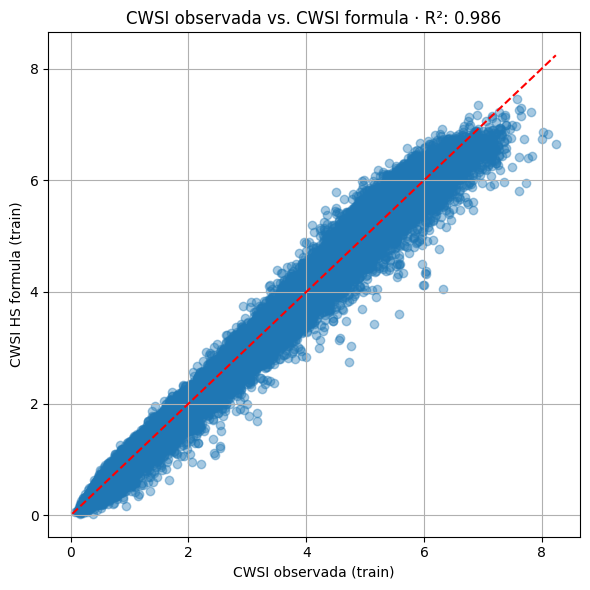

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
# Comparataiva dades reals amb dades físiques
rmse_hs_train = np.sqrt(mean_squared_error(y_train, ET0_PT_train_orig))
r2_hs_train   = r2_score(y_train, ET0_PT_train_orig)
r_hs_train = np.corrcoef(y_train, ET0_PT_train_orig)[0, 1]

print(f"RMSE HS (train): {rmse_hs_train:.3f} mm/dia")
print(f"R²   HS (train): {r2_hs_train:.3f}")
print(f"R    HS (train): {r_hs_train:.3f}")

# Comparació dades reals amb dades físiques.
plt.figure(figsize=(6,6))
plt.scatter(y_train, ET0_PT_train_orig, alpha=0.4)
mn = min(y_train.min(), ET0_PT_train_orig.min())
mx = max(y_train.max(), ET0_PT_train_orig.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("CWSI observada (train)")
plt.ylabel("CWSI HS formula (train)")
plt.title(f"CWSI observada vs. CWSI formula · R²: {r2_hs_train:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Creació conjunts de dades combiants desde reals i dades de funció física
# Entrada a la funció de perdua
y_train_combined = np.hstack([y_train_scaled[:, np.newaxis], ET0_PT_train_scaled[:, np.newaxis]])
y_test_combined  = np.hstack([y_test_scaled[:, np.newaxis],  ET0_PT_test_scaled[:, np.newaxis]])

In [ ]:
# Funció de pèrdua per la PINN.
def make_pinn_loss(theta=0.0):
    def pinn_loss(y_true_combined, y_pred):
         # Extracció dades
        y_data_scaled = tf.expand_dims(y_true_combined[:, 0], axis=1)
        y_phys_scaled = tf.expand_dims(y_true_combined[:, 1], axis=1)

        # Pèrdua de dades
        loss_data = tf.reduce_mean(tf.square(y_data_scaled - y_pred))

        # MSE de física
        loss_phys = tf.reduce_mean(tf.square(y_phys_scaled - y_pred))

        # Pèrdua total
        return (1.0 - theta) * loss_data + theta * loss_phys
    return pinn_loss

In [ ]:
# Adaptem varaible catefgoria a format
X_clima_train = X_clima_train.astype(np.int32)
X_clima_test = X_clima_test.astype(np.int32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras import regularizers

# Definició model de la xarxa neuronal informada per la física (PINN).
class SimplePINN(Model):
    def __init__(self, num_classes_clima, **kwargs):
        super().__init__(**kwargs)

        self.embedding_clima = Embedding(input_dim=num_classes_clima, output_dim=4, name="Embedding_Clima")
        self.flatten_clima = Flatten(name="Flatten_Clima")
        self.concatenate = Concatenate(name="Concatenate_Inputs")

        # Definir model
        self.dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.dropout1 = Dropout(0.4)
        self.dense2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):

        input_num, input_clima = inputs

        emb = self.embedding_clima(input_clima)

        emb_flat = self.flatten_clima(emb)

        x = self.concatenate([input_num, emb_flat])


        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        return self.output_layer(x)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
import time
import random
import os

# Configuració de seeds
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Crear carpeta d’emissions si no existeix
os.makedirs("emissions", exist_ok=True)

# Llista de thetas per iteració.
thetas = np.arange(0, 1.01, 0.05)

# Resultats i històries
results = []
histories = {}

for theta in thetas:
    print(f"Entrenant amb θ = {theta:.2f}…")
    K.clear_session()

    # Defineix pèrdua i model
    loss_fn = make_pinn_loss(theta=theta)
    model = SimplePINN(num_classes_clima=num_classes_clima)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss_fn,
        metrics=['mae']
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=25, restore_best_weights=True, verbose=0
    )

    # Emissions + temps
    tracker = EmissionsTracker(
        project_name=f"PINN_theta_{theta:.2f}",
        output_dir="emissions"
    )
    tracker.start()
    start_time = time.time()

    # Entrenament
    history = model.fit(
        x=[X_num_train_scaled, X_clima_train],
        y=y_train_combined,
        validation_data=([X_num_test_scaled, X_clima_test], y_test_combined),
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    elapsed = time.time() - start_time
    emissions = tracker.stop()

    histories[theta] = history.history

    # Predicció i mètriques
    y_pred_s = model.predict([X_num_test_scaled, X_clima_test]).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_val   = r2_score(y_true, y_pred)
    r_val    = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"θ={theta:.2f} → RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}, r: {r_val:.4f}, CO₂={emissions:.6f} kg, Temps={elapsed:.1f}s")

    results.append({
        'theta': theta,
        'rmse': rmse_val,
        'r2': r2_val,
        'r': r_val,
        'emissions_kg': emissions,
        'temps_s': elapsed
    })

# Desa resultats
df_results = pd.DataFrame(results)
df_results.to_csv("/resultats/resultats_EVO_P_PINNS.csv", index=False)


[codecarbon WARNING @ 14:06:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:06:34] [setup] RAM Tracking...
[codecarbon INFO @ 14:06:34] [setup] CPU Tracking...


Entrenant amb θ = 0.00…


[codecarbon WARNING @ 14:06:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:06:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:06:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:06:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:06:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:06:36] No GPU found.
[codecarbon INFO @ 14:06:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 14:06:36] >>> Tracker's metadata:
[codecarbon INFO @ 14:06:36]   Platform system: Linux-6

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.00 → RMSE: 0.1751, R²: 0.9903, r: 0.9951, CO₂=0.001127 kg, Temps=170.8s
Entrenant amb θ = 0.05…


[codecarbon WARNING @ 14:09:29] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:09:29] [setup] RAM Tracking...
[codecarbon INFO @ 14:09:29] [setup] CPU Tracking...
[codecarbon WARNING @ 14:09:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:09:30] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:09:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:09:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:09:30] [setup] GPU Tracking...
[codecarbon INFO @ 14:09:30] No GPU found.
[codecarbon INFO @ 14:09:30] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.05 → RMSE: 0.1834, R²: 0.9893, r: 0.9949, CO₂=0.001117 kg, Temps=169.2s
Entrenant amb θ = 0.10…


[codecarbon WARNING @ 14:12:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:12:21] [setup] RAM Tracking...
[codecarbon INFO @ 14:12:21] [setup] CPU Tracking...
[codecarbon WARNING @ 14:12:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:12:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:12:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:12:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:12:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:12:22] No GPU found.
[codecarbon INFO @ 14:12:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.10 → RMSE: 0.2333, R²: 0.9827, r: 0.9943, CO₂=0.001028 kg, Temps=155.7s
Entrenant amb θ = 0.15…


[codecarbon WARNING @ 14:15:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:15:00] [setup] RAM Tracking...
[codecarbon INFO @ 14:15:00] [setup] CPU Tracking...
[codecarbon WARNING @ 14:15:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:15:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:15:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:15:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:15:01] [setup] GPU Tracking...
[codecarbon INFO @ 14:15:01] No GPU found.
[codecarbon INFO @ 14:15:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.15 → RMSE: 0.1850, R²: 0.9891, r: 0.9951, CO₂=0.001297 kg, Temps=196.5s
Entrenant amb θ = 0.20…


[codecarbon WARNING @ 14:18:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:18:20] [setup] RAM Tracking...
[codecarbon INFO @ 14:18:20] [setup] CPU Tracking...
[codecarbon WARNING @ 14:18:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:18:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:18:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:18:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:18:21] [setup] GPU Tracking...
[codecarbon INFO @ 14:18:21] No GPU found.
[codecarbon INFO @ 14:18:21] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.20 → RMSE: 0.1998, R²: 0.9873, r: 0.9943, CO₂=0.001071 kg, Temps=162.4s
Entrenant amb θ = 0.25…


[codecarbon WARNING @ 14:21:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:21:05] [setup] RAM Tracking...
[codecarbon INFO @ 14:21:05] [setup] CPU Tracking...
[codecarbon WARNING @ 14:21:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:21:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:21:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:21:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:21:06] [setup] GPU Tracking...
[codecarbon INFO @ 14:21:06] No GPU found.
[codecarbon INFO @ 14:21:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.25 → RMSE: 0.1864, R²: 0.9890, r: 0.9949, CO₂=0.001071 kg, Temps=162.3s
Entrenant amb θ = 0.30…


[codecarbon WARNING @ 14:23:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:23:51] [setup] RAM Tracking...
[codecarbon INFO @ 14:23:51] [setup] CPU Tracking...
[codecarbon WARNING @ 14:23:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:23:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:23:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:23:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:23:52] [setup] GPU Tracking...
[codecarbon INFO @ 14:23:52] No GPU found.
[codecarbon INFO @ 14:23:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.30 → RMSE: 0.1842, R²: 0.9892, r: 0.9948, CO₂=0.001042 kg, Temps=158.0s
Entrenant amb θ = 0.35…


[codecarbon WARNING @ 14:26:31] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:26:31] [setup] RAM Tracking...
[codecarbon INFO @ 14:26:31] [setup] CPU Tracking...
[codecarbon WARNING @ 14:26:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:26:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:26:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:26:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:26:32] [setup] GPU Tracking...
[codecarbon INFO @ 14:26:32] No GPU found.
[codecarbon INFO @ 14:26:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.35 → RMSE: 0.2018, R²: 0.9871, r: 0.9947, CO₂=0.001190 kg, Temps=180.4s
Entrenant amb θ = 0.40…


[codecarbon WARNING @ 14:29:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:29:35] [setup] RAM Tracking...
[codecarbon INFO @ 14:29:35] [setup] CPU Tracking...
[codecarbon WARNING @ 14:29:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:29:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:29:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:29:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:29:36] [setup] GPU Tracking...
[codecarbon INFO @ 14:29:36] No GPU found.
[codecarbon INFO @ 14:29:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.40 → RMSE: 0.2008, R²: 0.9872, r: 0.9944, CO₂=0.000006 kg, Temps=172.0s
Entrenant amb θ = 0.45…


[codecarbon WARNING @ 14:32:30] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:32:30] [setup] RAM Tracking...
[codecarbon INFO @ 14:32:30] [setup] CPU Tracking...
[codecarbon WARNING @ 14:32:31] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:32:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:32:31] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:32:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:32:31] [setup] GPU Tracking...
[codecarbon INFO @ 14:32:31] No GPU found.
[codecarbon INFO @ 14:32:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.45 → RMSE: 0.1993, R²: 0.9874, r: 0.9947, CO₂=0.000005 kg, Temps=150.6s
Entrenant amb θ = 0.50…


[codecarbon WARNING @ 14:35:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:35:05] [setup] RAM Tracking...
[codecarbon INFO @ 14:35:05] [setup] CPU Tracking...
[codecarbon WARNING @ 14:35:06] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:35:06] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:35:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:35:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:35:06] [setup] GPU Tracking...
[codecarbon INFO @ 14:35:06] No GPU found.
[codecarbon INFO @ 14:35:06] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
θ=0.50 → RMSE: 0.2636, R²: 0.9779, r: 0.9937, CO₂=0.001087 kg, Temps=164.8s
Entrenant amb θ = 0.55…


[codecarbon WARNING @ 14:37:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:37:54] [setup] RAM Tracking...
[codecarbon INFO @ 14:37:54] [setup] CPU Tracking...
[codecarbon WARNING @ 14:37:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:37:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:37:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:37:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:37:55] [setup] GPU Tracking...
[codecarbon INFO @ 14:37:55] No GPU found.
[codecarbon INFO @ 14:37:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.55 → RMSE: 0.2040, R²: 0.9868, r: 0.9943, CO₂=0.000961 kg, Temps=145.7s
Entrenant amb θ = 0.60…


[codecarbon WARNING @ 14:40:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:40:24] [setup] RAM Tracking...
[codecarbon INFO @ 14:40:24] [setup] CPU Tracking...
[codecarbon WARNING @ 14:40:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:40:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:40:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:40:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:40:26] [setup] GPU Tracking...
[codecarbon INFO @ 14:40:26] No GPU found.
[codecarbon INFO @ 14:40:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
θ=0.60 → RMSE: 0.1936, R²: 0.9881, r: 0.9945, CO₂=0.000006 kg, Temps=174.4s
Entrenant amb θ = 0.65…


[codecarbon WARNING @ 14:43:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:43:23] [setup] RAM Tracking...
[codecarbon INFO @ 14:43:23] [setup] CPU Tracking...
[codecarbon WARNING @ 14:43:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:43:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:43:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:43:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:43:24] [setup] GPU Tracking...
[codecarbon INFO @ 14:43:24] No GPU found.
[codecarbon INFO @ 14:43:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
θ=0.65 → RMSE: 0.2048, R²: 0.9867, r: 0.9943, CO₂=0.001266 kg, Temps=191.8s
Entrenant amb θ = 0.70…


[codecarbon WARNING @ 14:46:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:46:38] [setup] RAM Tracking...
[codecarbon INFO @ 14:46:38] [setup] CPU Tracking...
[codecarbon WARNING @ 14:46:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:46:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:46:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:46:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:46:39] [setup] GPU Tracking...
[codecarbon INFO @ 14:46:39] No GPU found.
[codecarbon INFO @ 14:46:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.70 → RMSE: 0.1962, R²: 0.9878, r: 0.9942, CO₂=0.001274 kg, Temps=193.1s
Entrenant amb θ = 0.75…


[codecarbon WARNING @ 14:49:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:49:54] [setup] RAM Tracking...
[codecarbon INFO @ 14:49:54] [setup] CPU Tracking...
[codecarbon WARNING @ 14:49:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:49:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:49:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:49:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:49:55] [setup] GPU Tracking...
[codecarbon INFO @ 14:49:55] No GPU found.
[codecarbon INFO @ 14:49:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.75 → RMSE: 0.2329, R²: 0.9828, r: 0.9937, CO₂=0.000006 kg, Temps=178.8s
Entrenant amb θ = 0.80…


[codecarbon WARNING @ 14:52:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:52:56] [setup] RAM Tracking...
[codecarbon INFO @ 14:52:56] [setup] CPU Tracking...
[codecarbon WARNING @ 14:52:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:52:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:52:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 14:52:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:52:57] [setup] GPU Tracking...
[codecarbon INFO @ 14:52:57] No GPU found.
[codecarbon INFO @ 14:52:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.80 → RMSE: 0.1953, R²: 0.9879, r: 0.9939, CO₂=0.003855 kg, Temps=584.4s
Entrenant amb θ = 0.85…


[codecarbon WARNING @ 15:02:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:02:43] [setup] RAM Tracking...
[codecarbon INFO @ 15:02:43] [setup] CPU Tracking...
[codecarbon WARNING @ 15:02:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:02:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:02:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:02:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:02:45] [setup] GPU Tracking...
[codecarbon INFO @ 15:02:45] No GPU found.
[codecarbon INFO @ 15:02:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.85 → RMSE: 0.2121, R²: 0.9857, r: 0.9936, CO₂=0.001025 kg, Temps=155.3s
Entrenant amb θ = 0.90…


[codecarbon WARNING @ 15:05:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:05:22] [setup] RAM Tracking...
[codecarbon INFO @ 15:05:22] [setup] CPU Tracking...
[codecarbon WARNING @ 15:05:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:05:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:05:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:05:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:05:23] [setup] GPU Tracking...
[codecarbon INFO @ 15:05:23] No GPU found.
[codecarbon INFO @ 15:05:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=0.90 → RMSE: 0.2165, R²: 0.9851, r: 0.9935, CO₂=0.000006 kg, Temps=165.2s
Entrenant amb θ = 0.95…


[codecarbon WARNING @ 15:08:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:08:11] [setup] RAM Tracking...
[codecarbon INFO @ 15:08:11] [setup] CPU Tracking...
[codecarbon WARNING @ 15:08:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:08:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:08:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:08:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:08:12] [setup] GPU Tracking...
[codecarbon INFO @ 15:08:12] No GPU found.
[codecarbon INFO @ 15:08:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
θ=0.95 → RMSE: 0.2027, R²: 0.9869, r: 0.9935, CO₂=0.001131 kg, Temps=171.4s
Entrenant amb θ = 1.00…


[codecarbon WARNING @ 15:11:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:11:07] [setup] RAM Tracking...
[codecarbon INFO @ 15:11:07] [setup] CPU Tracking...
[codecarbon WARNING @ 15:11:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:11:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:11:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 15:11:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:11:08] [setup] GPU Tracking...
[codecarbon INFO @ 15:11:08] No GPU found.
[codecarbon INFO @ 15:11:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
θ=1.00 → RMSE: 0.2092, R²: 0.9861, r: 0.9931, CO₂=0.003394 kg, Temps=514.5s


In [16]:
print(model.summary())

Model: "simple_pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_Clima (Embedding)          │ (None, 4)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Clima (Flatten)              │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Concatenate_Inputs (Concatenate)     │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,213 (32.09 KB)

 Trainable params: 2,737 (10.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,476 (21.39 KB)

None


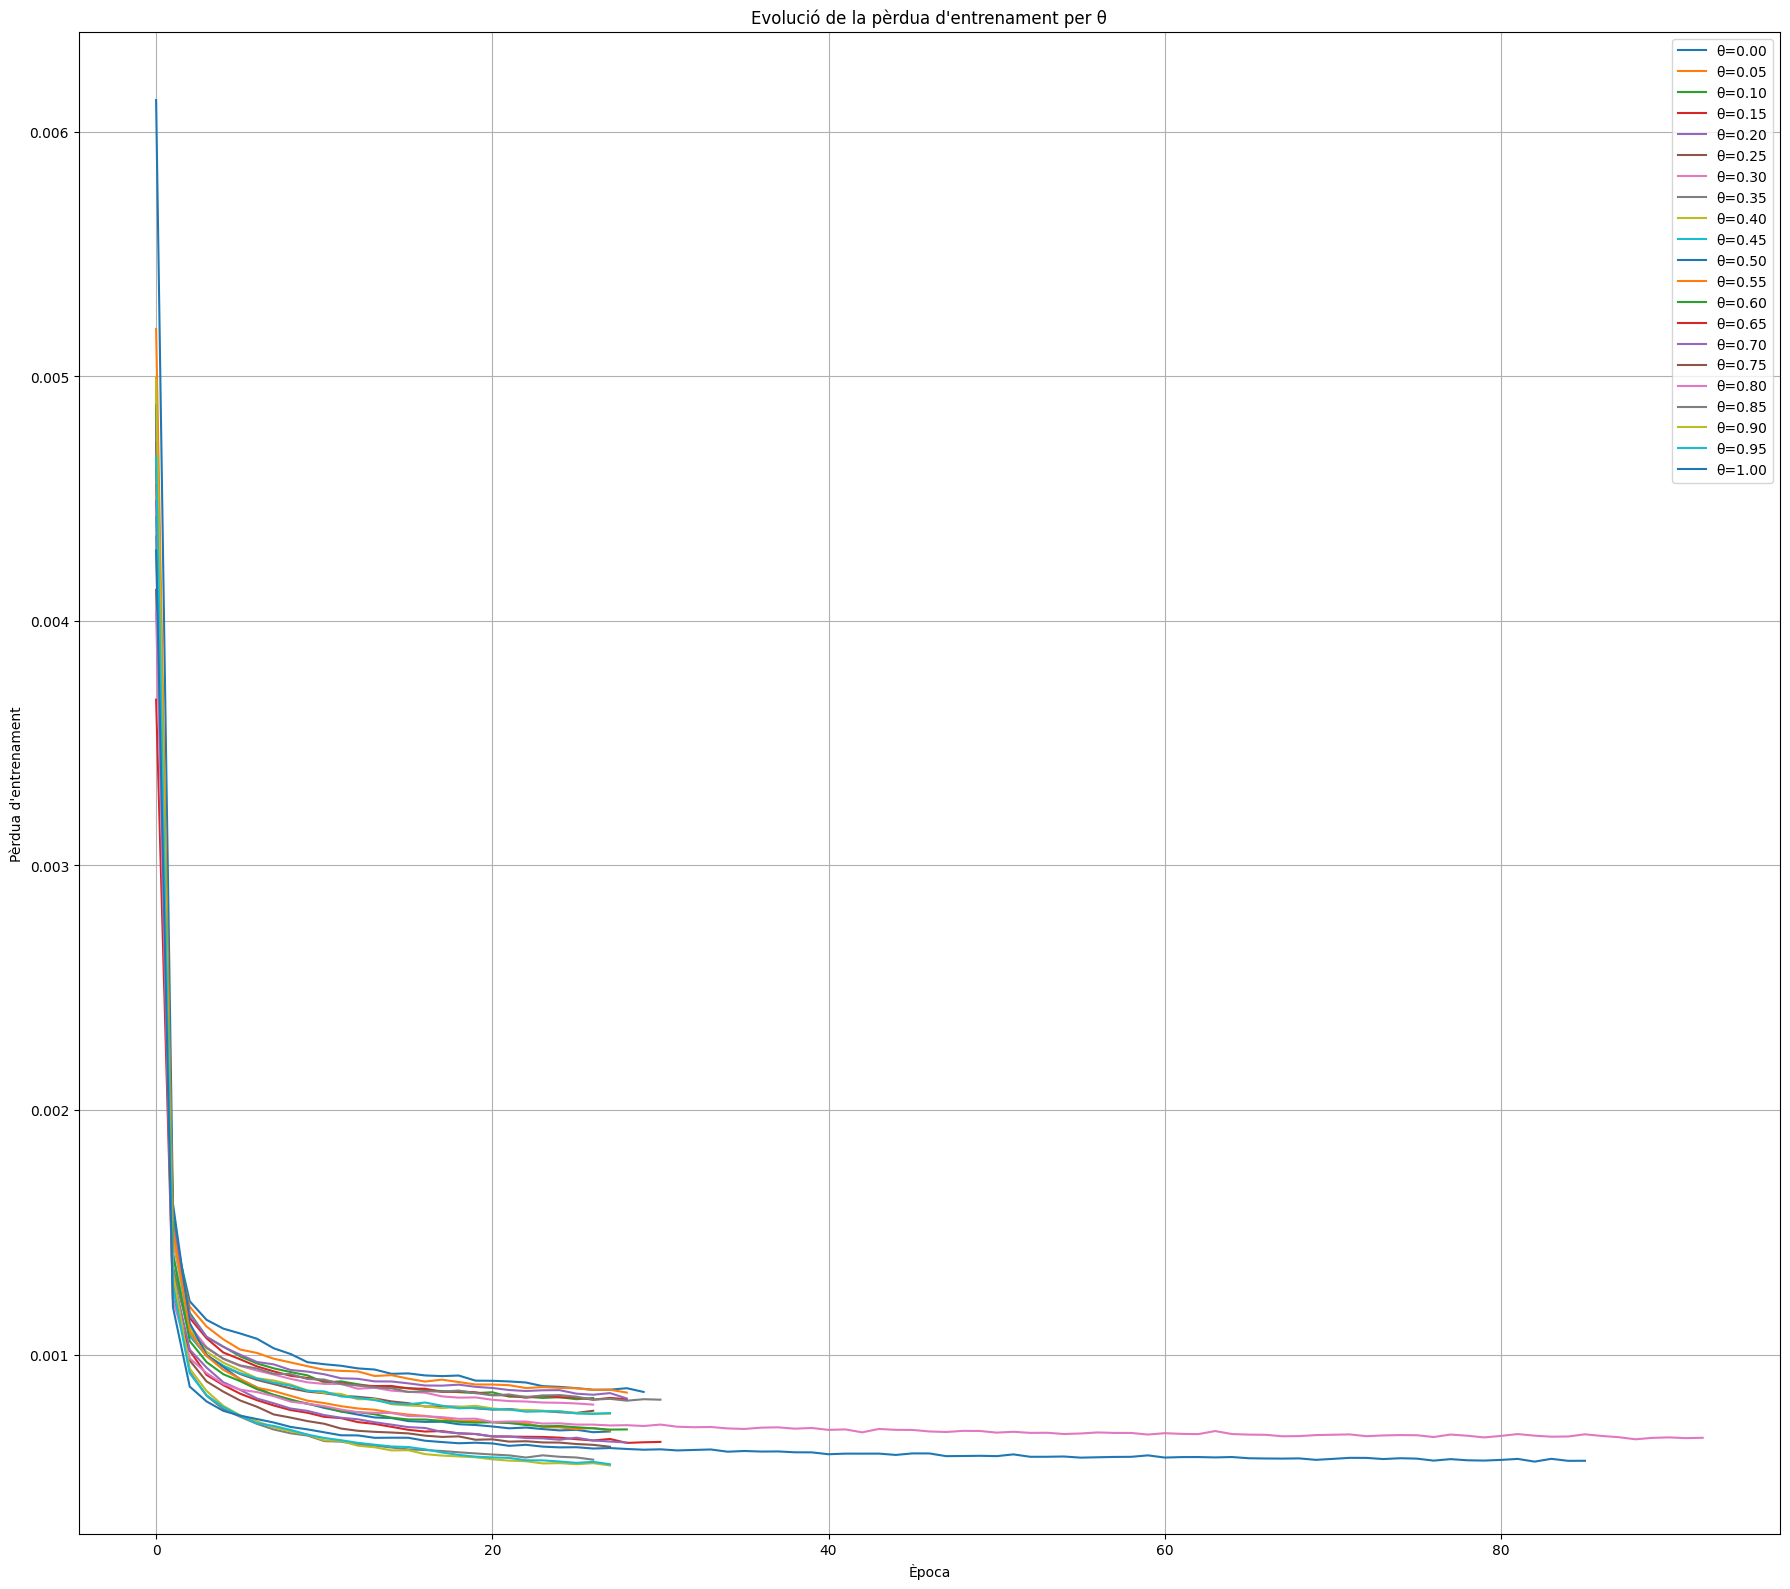

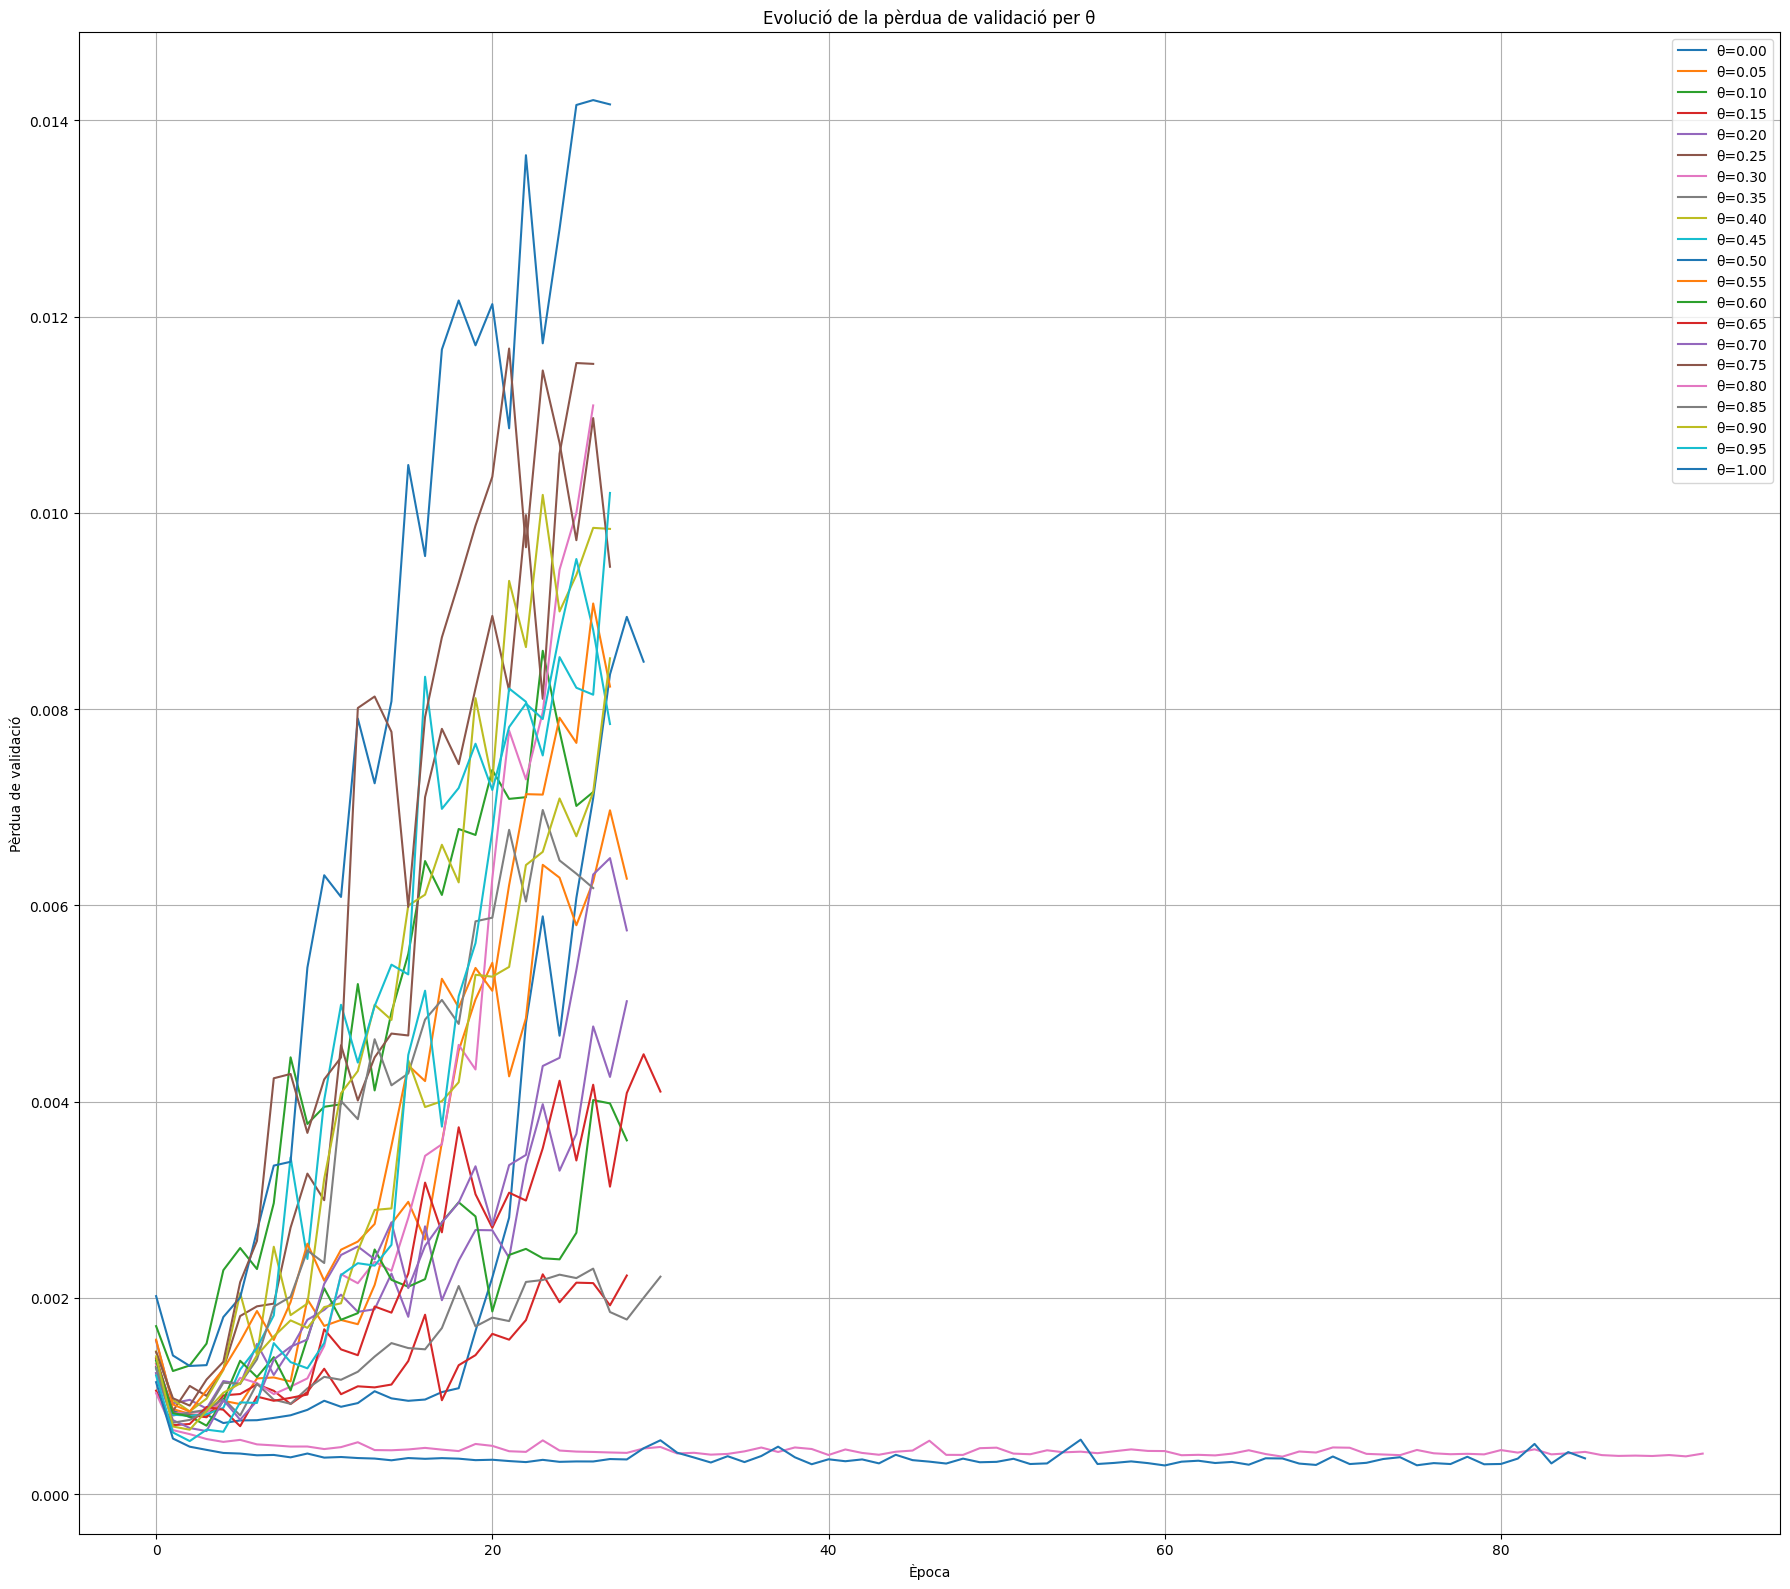

In [17]:
import matplotlib.pyplot as plt

# 1. Evolució de la pèrdua d'entrenament
plt.figure(figsize=(18, 16))
for theta, hist in histories.items():
    plt.plot(hist['loss'], label=f'θ={theta:.2f}')
plt.title("Evolució de la pèrdua d'entrenament per θ")
plt.xlabel("Època")
plt.ylabel("Pèrdua d'entrenament")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("perdua_train_epochs_per_theta.png")
plt.show()

# 2. Evolució de la pèrdua de validació
plt.figure(figsize=(18, 16))
for theta, hist in histories.items():
    plt.plot(hist['val_loss'], label=f'θ={theta:.2f}')
plt.title("Evolució de la pèrdua de validació per θ")
plt.xlabel("Època")
plt.ylabel("Pèrdua de validació")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("perdua_val_epochs_per_theta.png")
plt.show()
